In [1]:
import numpy as np
import matplotlib.pyplot as plt
from fem.mesh import GenMesh

In [2]:
Nele = 80

xyz = (-2, 2, -2, 2, -4.0, 0.0)
numElem = (Nele, Nele, Nele)
GenMesh.run(xyz,numElem)

with open("nodes.dyn", 'r') as f:
    a = f.readlines()

aprime = a[2:-1]
del a

nodes = {}
coords = []
for a in aprime:
    splits = a[:-1].split(",")
    label = splits[0]
    coord = [float(A) for A in splits[1:]]
    nodes[label] = np.array(coord)
    coords.append(coord)

coords = np.array(coords)
x = np.unique(coords[:,0])
x.sort()
y = np.unique(coords[:,1])
y.sort()
z = np.unique(coords[:,2])
z[::-1].sort()
del coords

with open("elems.dyn", 'r') as f:
    a = f.readlines()

aprime = a[2:-1]
del a

elems = {}
for a in aprime:
    # removed the newline and split the node definitions
    splits = a[:-1].split(",")
    elem = {
        'matid' : splits[1],
        'nodes' : splits[2:]
    }

    centroid = 0
    for node_id in elem['nodes']:
        centroid += nodes[node_id]/len(elem['nodes'])

    
    elem['centroid'] = centroid

    # save the element structure
    elems[splits[0]] = elem

INFO:fem.mesh.GenMesh:531441/531441 nodes written to nodes.dyn
INFO:fem.mesh.GenMesh:512000/512000 elements written to elems.dyn


In [3]:
# Define multiple materials
elemmap = np.ones((Nele, Nele))

for inda in range(0, Nele-2, 3):
    scale = int(((inda/3) % 2) * 2)
    for inde in range(0, Nele-2, 4):
        elemmap[(inda):(inda+3), inde+1+scale] = 2
        elemmap[inda+1, (inde+scale):(inde+3+scale)] = 2

DEBUG:matplotlib.pyplot:Loaded backend module://matplotlib_inline.backend_inline version unknown.
DEBUG:matplotlib.pyplot:Loaded backend module://matplotlib_inline.backend_inline version unknown.
DEBUG:matplotlib.font_manager:findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/home/wren/.local/lib/python3.10/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSerif-Bold.ttf', name='DejaVu Serif', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/home/wren/.local/lib/python3.10/site-packages/matplotlib/mpl-data/fonts/ttf/STIXSizFiveSymReg.ttf', name='STIXSizeFiveSym', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/home/wren/.local/lib/python3.10/site-packages/matplotlib/m

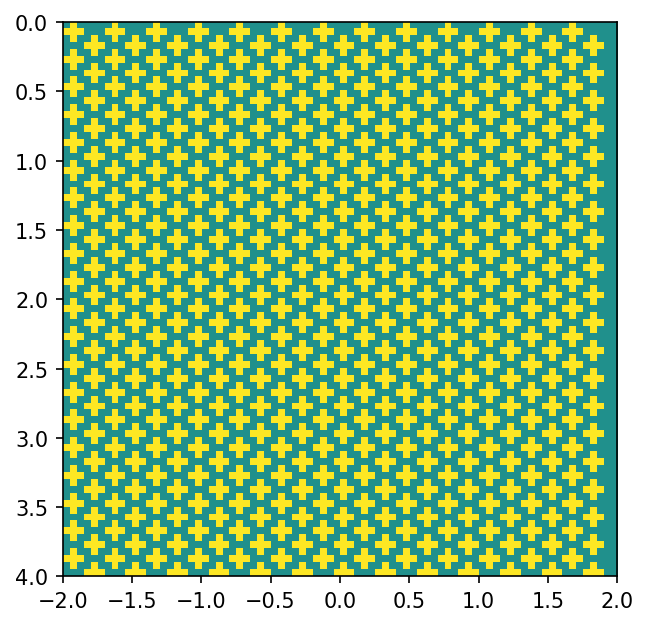

In [4]:
plt.figure(dpi=150)
plt.imshow(elemmap.T, extent=[-2, 2, 4, 0], vmin=0, vmax=2)
plt.show()

In [5]:
# Define multiple materials
elemmap = np.ones((Nele, Nele))

astep = 4
scale0 = 4
for inda in range(0, Nele-2, astep):
    scale = int(((inda/astep) % 2) * scale0)
    for inde in range(0, Nele-2, 8):

        # cross
        elemmap[(inda):(inda+4), (inde+1+scale):(inde+3+scale)] = 2
        elemmap[(inda+1):(inda+3), (inde+scale):(inde+4+scale)] = 2

        # dot
        elemmap[(inda+1):(inda+3), (inde+1+scale+4):(inde+3+scale+4)] = 2

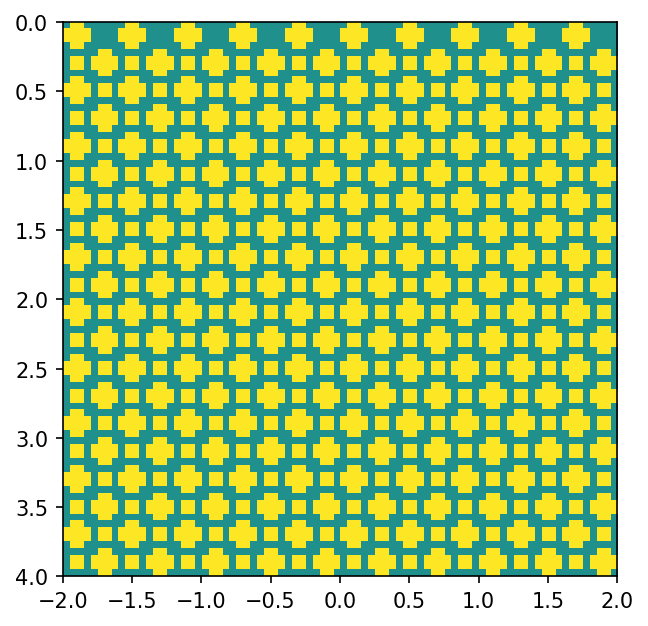

In [6]:
plt.figure(dpi=150)
plt.imshow(elemmap.T, extent=[-2, 2, 4, 0], vmin=0, vmax=2)
plt.show()

[-1.975 -1.975 -3.975]


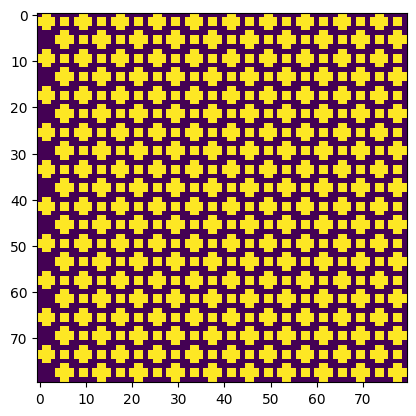

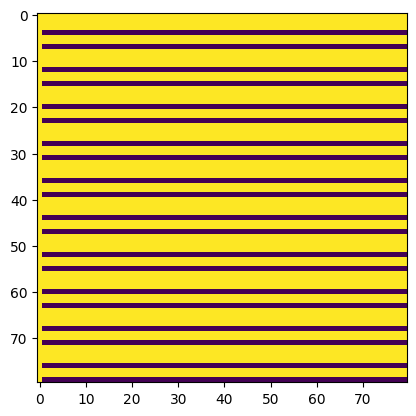

In [7]:
print(elems['1']['centroid'])

fullmap = elemmap.reshape((Nele, Nele, 1)) * np.ones((Nele, Nele, Nele))
fullmap[:,:,0] = 2

plt.figure()
plt.imshow(fullmap[:,:,Nele//2+2])
plt.show()

plt.figure()
plt.imshow(fullmap[:,Nele//2+2,:])
plt.show()

[-1.975 -1.975 -3.975]


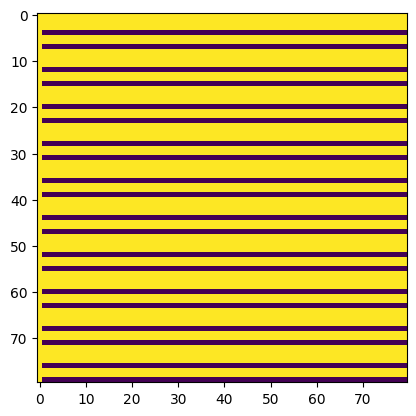

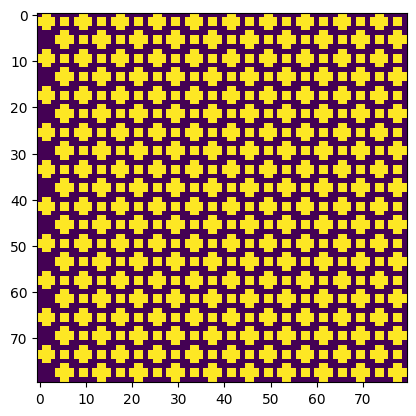

In [8]:
print(elems['1']['centroid'])

fullmap = elemmap.reshape((Nele, 1, Nele)) * np.ones((Nele, Nele, Nele))
fullmap[:,0,:] = 2

plt.figure()
plt.imshow(fullmap[:,:,Nele//2+2])
plt.show()

plt.figure()
plt.imshow(fullmap[:,Nele//2+2,:])
plt.show()

In [14]:
for key in elems.keys():
    xind = np.argmax(x > elems[key]['centroid'][0])-1
    yind = np.argmax(y > elems[key]['centroid'][1])-1
    zind = np.argmax(z < elems[key]['centroid'][2])-1
    
    elems[key]['matid'] = f"{int(fullmap[xind, yind, zind])}"

In [18]:
with open("elems.dyn", 'w') as f:
    f.write("")
with open("elems.dyn", 'a') as f:
    lines = "$ Written with custom fiber mapping\n*ELEMENT_SOLID\n"
    f.write(lines)
    for key in elems.keys():
        lines = f"{key},{elems[key]['matid']},"
        for node in elems[key]['nodes']:
            lines += node + ","
        lines = lines[:-1]
        lines += '\n'
        f.write(lines)
    lines = "*END\n"
    f.write(lines)